In [155]:
import pandas as pd
import numpy as np
import xgboost as xgb
from torch.ao.nn.quantized.functional import threshold
from xgboost import XGBRegressor
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
import shap

In [156]:
warnings.filterwarnings('ignore')

In [157]:
train_df_final = pd.read_csv('./input/processed/train_df_final_v5.csv')
test_df_final = pd.read_csv('./input/processed/test_df_final_v5.csv')

In [158]:
train_df_final.head()

,id,climatology_temp,target,elev,lat,lon,doy_sin,doy_cos,day_of_year,day_length,...,hum_pca1,hum_pca2,slp_pca1,slp_pca2,wind_pca1,wind_pca2,cloud_pca1,cloud_pca2,precip_pca1,precip_pca2
0,0,-2.707143,-3.992857,115.62,37.9019,127.0607,0.017213,0.999852,1,9.426812,...,-44.174162,0.012243,35.318138,-0.833324,-0.346942,0.820638,-2.017006,-1.935519,1208.941930,752.212943
1,1,-3.646429,-1.653571,115.62,37.9019,127.0607,0.034422,0.999407,2,9.437325,...,-48.024363,7.321567,36.785260,0.377317,-1.637682,-0.168122,-6.083274,-0.397254,1483.958436,-550.375188
2,2,-2.694643,-0.005357,115.62,37.9019,127.0607,0.051620,0.998667,3,9.448699,...,-52.573928,16.518909,38.582099,0.698330,-1.712214,-1.206722,-6.083274,-0.397254,1489.211203,-550.743985
3,3,-2.501786,-0.898214,115.62,37.9019,127.0607,0.068802,0.997630,4,9.460926,...,-31.007499,-15.890927,30.131834,-4.494970,-1.548832,0.075699,-3.781599,1.071908,1289.173590,802.529906
4,4,-2.625000,-1.775000,115.62,37.9019,127.0607,0.085965,0.996298,5,9.473997,...,-59.024818,12.811830,22.333693,1.012483,-0.714796,0.030204,-5.558634,-0.909790,1178.303267,-549.019773


# Dataset Splitting

In [159]:
features = [col for col in train_df_final.columns if col not in ['id', 'target']]

X = train_df_final[features].values
y = train_df_final['target'].values
X_test = test_df_final[features].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Optuna Setup

In [160]:
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 1000, 8000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 10.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'random_state': 32,
        'verbosity': 0
    }
    model = xgb.XGBRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False,
    )
    preds = model.predict(X_val)
    return root_mean_squared_error(y_val, preds)

In [161]:
# study = optuna.create_study(direction='minimize', study_name='xgb_reg_opt')
# study.optimize(objective, n_trials=250, n_jobs=-1)
# print("Best trial:")
# print(f"  RMSE: {study.best_value:.5f}")
# print(f"  Params: {study.best_params}")
#
# best_params = study.best_params.copy()
# best_params.update({
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     'random_state': 32,
#     'verbosity': 0
# })

In [162]:
best_params = {'n_estimators': 7686, 'learning_rate': 0.027367337212669172, 'max_depth': 5, 'subsample': 0.5959315110309751, 'colsample_bytree': 0.901155651474499, 'min_child_weight': 0.0072824350924899, 'gamma': 5.136565597520639e-08, 'reg_alpha': 0.00036520349232711184, 'reg_lambda': 4.6466639093441024}

# Train

In [163]:
xgb_model = xgb.XGBRegressor(**best_params)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

y_pred = xgb_model.predict(X_val)
r2 = r2_score(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
print(f"\n✅ XGB R²: {r2:.4f} | RMSE: {rmse:.4f}")


✅ XGB R²: 0.8410 | RMSE: 1.1938


# Feature Importance

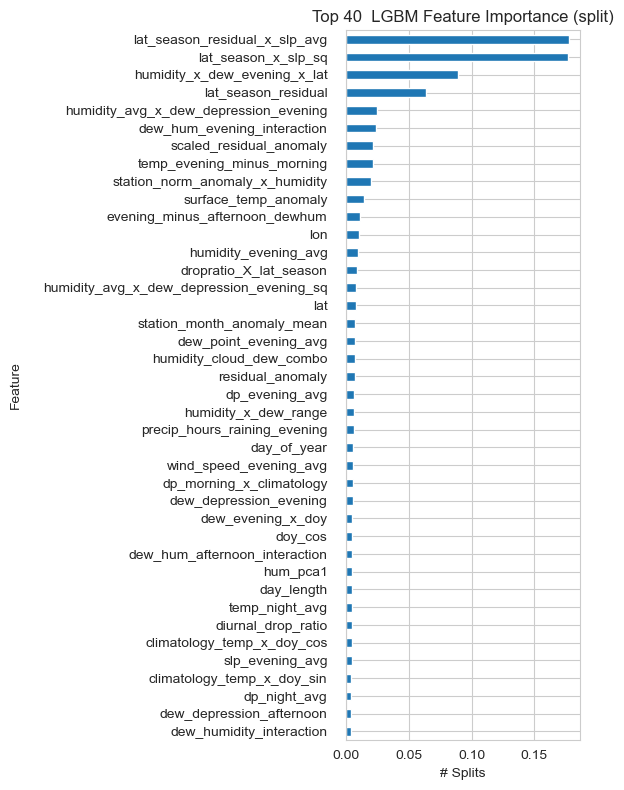

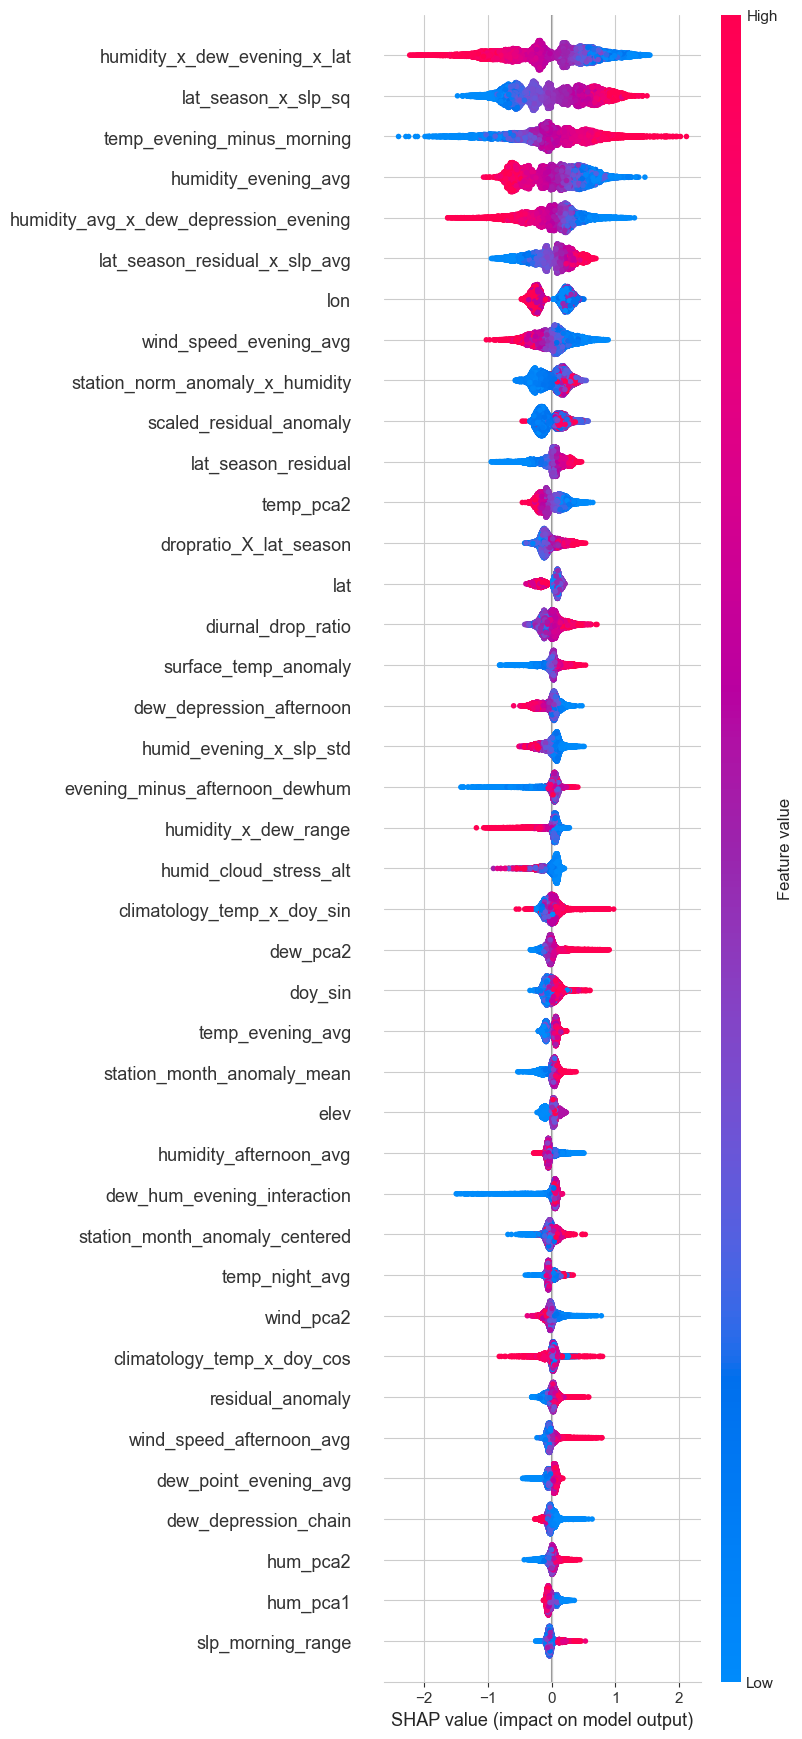

In [164]:
imp_split = xgb_model.feature_importances_

feat_imp_split = pd.Series(imp_split, index=features).sort_values(ascending=False)

top_N = 40

# 1) Plot split importances
fig, ax = plt.subplots(figsize=(6, 8))
feat_imp_split.head(top_N).plot(kind='barh', ax=ax)
ax.invert_yaxis()
ax.set_title(f'Top {top_N}  LGBM Feature Importance (split)')
ax.set_xlabel('# Splits')
ax.set_ylabel('Feature', labelpad=15)
ax.tick_params(axis='y', pad=10)
plt.subplots_adjust(left=0.3)
plt.tight_layout()
plt.show()

# 2) SHAP Summary Plots
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, max_display=top_N, feature_names=features)
mean_abs_shap = np.abs(shap_values).mean(axis=0)
feat_shap_imp = pd.Series(mean_abs_shap, index=features).sort_values(ascending=False)

In [165]:
print(f"Top {top_N} XGB Importances (split):")
print(feat_imp_split.head(top_N).to_string())
print("="*50)
print("Top SHAP Feature Importances (mean |SHAP value|):")
print(feat_shap_imp.head(top_N).to_string())

Top 40 XGB Importances (split):
lat_season_residual_x_slp_avg               0.177618
lat_season_x_slp_sq                         0.176664
humidity_x_dew_evening_x_lat                0.089215
lat_season_residual                         0.063491
humidity_avg_x_dew_depression_evening       0.024874
dew_hum_evening_interaction                 0.023748
scaled_residual_anomaly                     0.021258
temp_evening_minus_morning                  0.021052
station_norm_anomaly_x_humidity             0.019780
surface_temp_anomaly                        0.014488
evening_minus_afternoon_dewhum              0.010905
lon                                         0.009992
humidity_evening_avg                        0.008983
dropratio_X_lat_season                      0.008610
humidity_avg_x_dew_depression_evening_sq    0.007370
lat                                         0.007343
station_month_anomaly_mean                  0.007001
dew_point_evening_avg                       0.006967
humidity_cloud

# Feature Selection with SHAP

In [166]:
print("Lowest SHAP Importances:")
print(feat_shap_imp.tail(50).to_string())

Lowest SHAP Importances:
afternoon_night_slope             0.033589
precip_total_morning              0.033578
cloud_pca2                        0.033467
precip_total_evening              0.032158
wind_speed_morning_avg            0.030866
dew_point_afternoon_avg           0.030227
precip_total_night                0.029908
humidity_range                    0.029830
slp_afternoon_range               0.029312
dew_hum_morning_interaction       0.029141
temp_morning_avg                  0.028954
precip_pca2                       0.028354
slp_morning_avg                   0.028252
climatology_temp                  0.027938
cloud_cover_night_avg             0.027928
wind_speed_night_avg              0.027682
dew_hum_afternoon_interaction     0.026432
wind_speed_avg                    0.025599
doy_cos                           0.025176
cloud_cover_night_var             0.024882
cloud_cover_evening_var           0.024525
dew_depression_morning            0.023650
cloud_cover_afternoon_var    

# Predict with Test Dataset

In [170]:
y_test_pred = xgb_model.predict(X_test)

submission = pd.DataFrame({
    "id": test_df_final["id"],
    "target": y_test_pred
})

now = datetime.now().strftime("%Y%m%d_%H%M%S")

submission.to_csv(f'./output/submission_xgb_{now}.csv', index=False)